In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import scipy
import seaborn as sns
import glob
import cv2
from scipy import integrate
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout, Input
from keras.models import Sequential, Model
from keras.layers import Conv2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, VGG16, InceptionResNetV2
from tensorflow.keras import datasets, layers, models
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score


In [ ]:
import tensorflow as tf

# Check if GPU is available
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('No GPU found. Please make sure to enable GPU acceleration in Colab.')
else:
    print(gpu_info)

# Check if TensorFlow is using GPU
print('TensorFlow version:', tf.__version__)
print('GPU device:', tf.test.gpu_device_name())


Mon Nov 13 07:26:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# In order to run the code, please put the zip file in the google drive, mount it, and run the code to unzip it
# You may refer to the dataset_path to have a better understanding on the location hierarchy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/4483/archive.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/drive/MyDrive/4483')

In [ ]:
dataset_path = '/content/drive/MyDrive/4483/datasets'

# Data Exploration

In [ ]:
train_path = '/content/drive/MyDrive/4483/datasets/train'
categories = []
filenames = []
for folder_name in os.listdir(train_path):
    folder_dir = os.path.join(train_path, folder_name)
    if os.path.isdir(folder_dir):
        for filename in os.listdir(folder_dir):
            filenames.append(filename)
            if folder_name == 'dog':
                categories.append(1)
            else:
                categories.append(0)

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
display(train_df.head())
display(train_df.tail())
print(train_df['category'].value_counts())

validation_path = '/content/drive/MyDrive/4483/datasets/val'
categories = []
filenames = []
for folder_name in os.listdir(train_path):
    folder_dir = os.path.join(train_path, folder_name)
    if os.path.isdir(folder_dir):
        for filename in os.listdir(folder_dir):
            filenames.append(filename)
            if folder_name == 'dog':
                categories.append(1)
            else:
                categories.append(0)
validation_df = pd.DataFrame({
  'filename': filenames,
  'category': categories
})
display(validation_df.head())
display(validation_df.tail())
print(validation_df['category'].value_counts())

filename  category
0  cat.11446.jpg         0
1   cat.8372.jpg         0
2   cat.7041.jpg         0
3  cat.10770.jpg         0
4   cat.2139.jpg         0

filename  category
19995  dog.1631.jpg         1
19996  dog.5457.jpg         1
19997  dog.4991.jpg         1
19998  dog.2338.jpg         1
19999   dog.617.jpg         1

0    10000
1    10000
Name: category, dtype: int64


filename  category
0  cat.11446.jpg         0
1   cat.8372.jpg         0
2   cat.7041.jpg         0
3  cat.10770.jpg         0
4   cat.2139.jpg         0

filename  category
19995  dog.1631.jpg         1
19996  dog.5457.jpg         1
19997  dog.4991.jpg         1
19998  dog.2338.jpg         1
19999   dog.617.jpg         1

0    10000
1    10000
Name: category, dtype: int64


In [ ]:
train_df = pd.DataFrame({
    'filename': [os.path.join(train_path, folder_name, fname) for folder_name in os.listdir(train_path)
                 for fname in os.listdir(os.path.join(train_path, folder_name)) if os.path.isdir(os.path.join(train_path, folder_name))],
    'category': ['dog' if 'dog' in folder_name else 'cat' for folder_name in os.listdir(train_path)
                 for _ in os.listdir(os.path.join(train_path, folder_name)) if os.path.isdir(os.path.join(train_path, folder_name))]
})
validation_df = pd.DataFrame({
    'filename': [os.path.join(validation_path, folder_name, fname) for folder_name in os.listdir(validation_path)
                 for fname in os.listdir(os.path.join(validation_path, folder_name)) if os.path.isdir(os.path.join(validation_path, folder_name))],
    'category': ['dog' if 'dog' in folder_name else 'cat' for folder_name in os.listdir(validation_path)
                 for _ in os.listdir(os.path.join(validation_path, folder_name)) if os.path.isdir(os.path.join(validation_path, folder_name))]
})
validation_df.head()

filename category
0  /content/drive/MyDrive/4483/datasets/val/cat/c...      cat
1  /content/drive/MyDrive/4483/datasets/val/cat/c...      cat
2  /content/drive/MyDrive/4483/datasets/val/cat/c...      cat
3  /content/drive/MyDrive/4483/datasets/val/cat/c...      cat
4  /content/drive/MyDrive/4483/datasets/val/cat/c...      cat

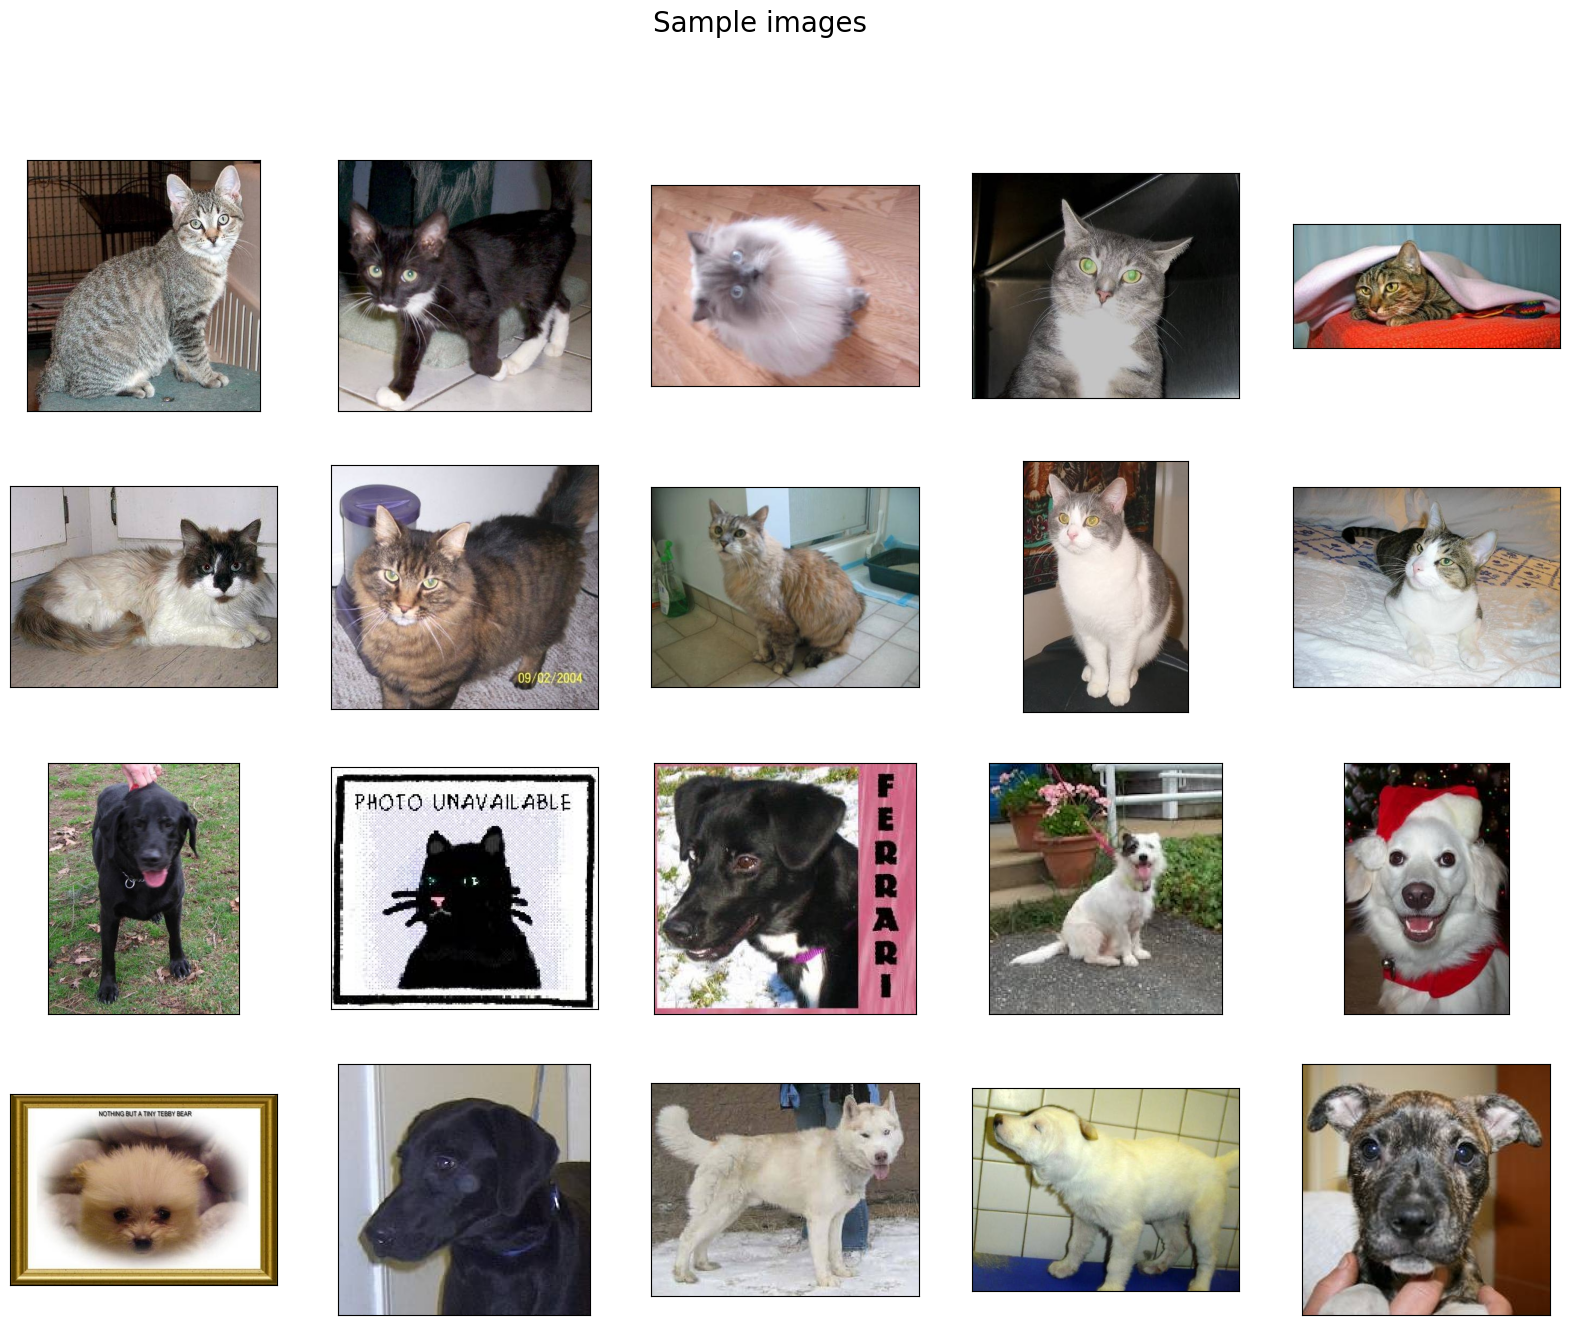

In [ ]:
plt.figure(figsize=(20,15))
plt.suptitle("Sample images", fontsize=20)
path = train_path + '/cat/'
counter = 1

for img in os.listdir(path):
    if counter <= 10:
        plt.subplot(4, 5, counter)
        full_image = plt.imread(path + img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(full_image, cmap=plt.cm.binary)
        counter += 1
    else:
        break

path = train_path + '/dog/'

for img in os.listdir(path):
    if counter <= 20:
        plt.subplot(4, 5, counter)
        full_image = plt.imread(path + img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(full_image, cmap=plt.cm.binary)
        counter += 1
    else:
        break

plt.show()


## Data Quantity Verification

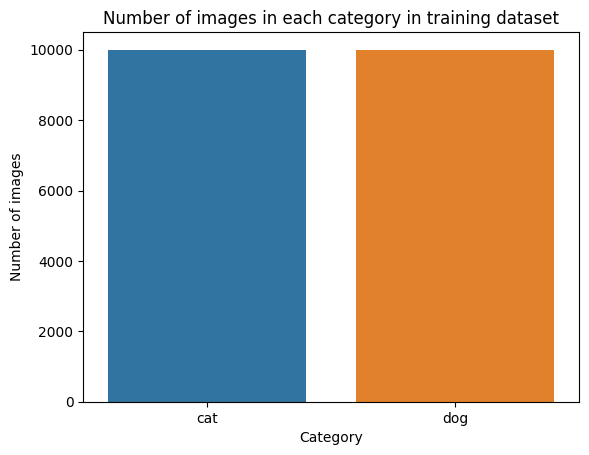

In [ ]:
plt.title('Number of images in each category in training dataset')
sns.countplot(x=train_df['category'])
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.show()

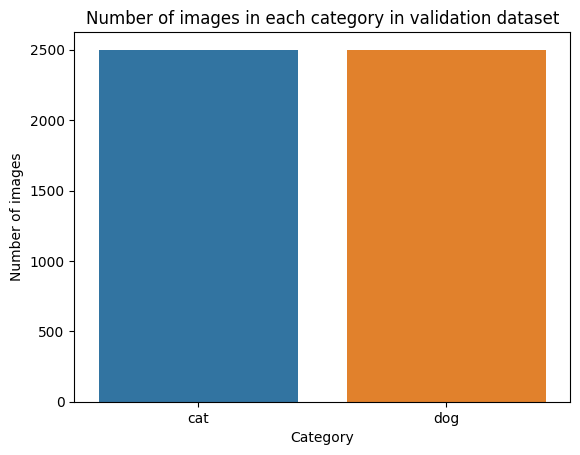

In [ ]:
plt.title('Number of images in each category in validation dataset')
sns.countplot(x=validation_df['category'])
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.show()

## Image Dimension Analysis

In [ ]:
from PIL import Image
widths = []
heights = []
channels = []

for folder_name in os.listdir(train_path):
    folder_dir = os.path.join(train_path, folder_name)
    if os.path.isdir(folder_dir):
      for filename in os.listdir(folder_dir):
        file_path = os.path.join(folder_dir, filename)
        with Image.open(file_path) as img:
          width, height = img.size
          num_channels = len(img.getbands())
          widths.append(width)
          heights.append(height)
          channels.append(num_channels)
dim_df = pd.DataFrame({
  'width': widths,
  'height': heights,
  'channels': channels
})
print(f'Average width: {np.mean(widths)} pixels')
print(f'Average height: {np.mean(heights)} pixels')
channel_counts = dim_df['channels'].value_counts()
print(channel_counts)
display(dim_df.describe())

Average width: 404.3463 pixels
Average height: 361.01265 pixels
3    20000
Name: channels, dtype: int64


width        height  channels
count  20000.000000  20000.000000   20000.0
mean     404.346300    361.012650       3.0
std      108.918243     96.934388       0.0
min       42.000000     32.000000       3.0
25%      323.000000    302.000000       3.0
50%      448.000000    374.000000       3.0
75%      499.000000    421.000000       3.0
max     1050.000000    768.000000       3.0

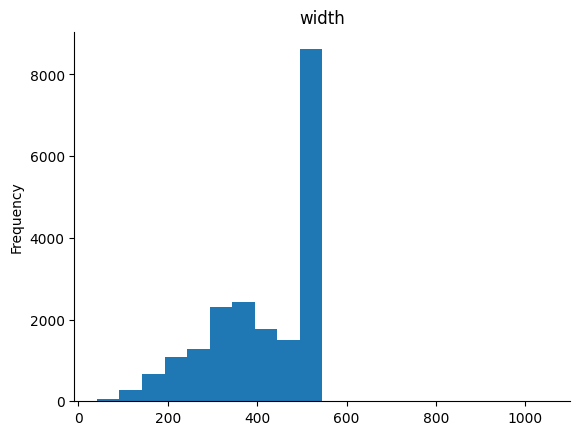

In [ ]:
from matplotlib import pyplot as plt
_df_0 = dim_df
_df_0['width'].plot(kind='hist', bins=20, title='width')
plt.gca().spines[['top', 'right',]].set_visible(False)

#this means we need to perform some preprocessing for normalization

## Sample Visualization

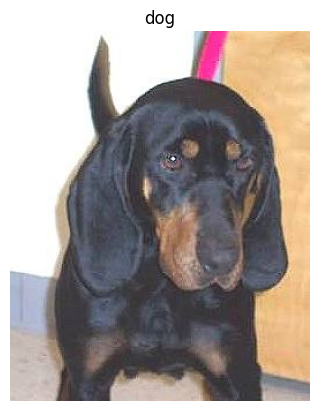

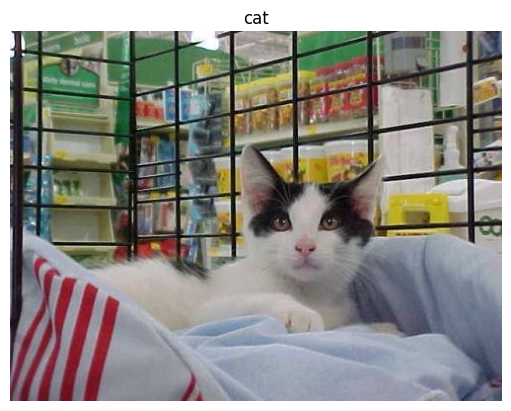

In [ ]:
dogs_df = train_df[train_df['category'] == 1]
cats_df = train_df[train_df['category'] == 0]
random_dog = dogs_df.sample(1)
random_cat = cats_df.sample(1)
def load_and_display_image(filename, folder):
  file_path = os.path.join(train_path, folder, filename)
  img = Image.open(file_path)
  plt.imshow(img)
  plt.axis('off')
  plt.title(folder)
  plt.show()
load_and_display_image(random_dog['filename'].values[0], 'dog')
load_and_display_image(random_cat['filename'].values[0], 'cat')

# Data Preprocessing

In [ ]:
batch_size = 256
target_size = (100, 100)

In [ ]:
from sklearn.model_selection import train_test_split
new_validation_df, test_df = train_test_split(validation_df, test_size=0.2)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
validation_path = '/content/drive/MyDrive/4483/datasets/val'

new_validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=new_validation_df,
    directory=validation_path,
    x_col='filename',
    y_col='category',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = validation_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=validation_path,
    x_col='filename',
    y_col='category',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


## Data Augmentation and Resizing

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
train_datagen = ImageDataGenerator(
  rescale = 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = True,
  fill_mode = 'nearest'
)
params = {
    "lr": 0.001,
    "batch_size": batch_size,
    "n_epochs": 1,
    "image_size": 100,
    "dropout_rate": 0.5,
}
# Pre-calculated values, use this to save on time
mean = [0.48846444487571716, 0.45509546995162964, 0.4170514643192291]
std = [0.23550905287265778, 0.23108406364917755, 0.23146183788776398]
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Resize((params["image_size"], params["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform=train_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params["batch_size"],
                                          shuffle=True)

Files already downloaded and verified


In [ ]:
train_path = "/content/drive/MyDrive/4483/datasets/train"
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.


# Model Selection

## Baseline Model Establishment

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf
tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(100, 100, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 activation (Activation)     (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 32)                1280032   
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                        

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=new_validation_generator,
    validation_steps=new_validation_generator.samples // new_validation_generator.batch_size
)

Epoch 1/5
78/78 [==============================] - 92s 1s/step - loss: 0.9248 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4971
Epoch 2/5
78/78 [==============================] - 90s 1s/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 3/5
78/78 [==============================] - 90s 1s/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 4/5
78/78 [==============================] - 90s 1s/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 5/5
78/78 [==============================] - 91s 1s/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.4966


In [ ]:
test_steps = (test_generator.samples + test_generator.batch_size - 1) // test_generator.batch_size

baseline_test_loss, baseline_test_accuracy = model.evaluate(
    test_generator,
    steps=test_steps
)

print(f"Test Loss: {baseline_test_loss}")
print(f"Test Accuracy: {baseline_test_accuracy}")

4/4 [==============================] - 2s 527ms/step - loss: 0.6931 - accuracy: 0.5100
Test Loss: 0.6931195259094238
Test Accuracy: 0.5099999904632568


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_classes, predicted_classes)
print('Validation Accuracy = %.2f' % (accuracy * 100))
#very low accuracy

Validation Accuracy = 49.75


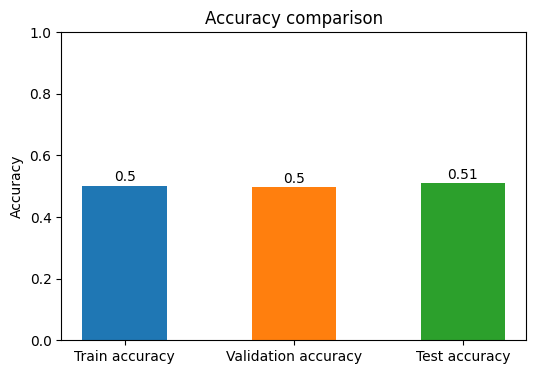

In [ ]:
data = {
    'Train accuracy': history.history['accuracy'][0],
    'Validation accuracy': history.history['val_accuracy'][0],
    'Test accuracy': baseline_test_accuracy
}
datasets = list(data.keys())
accuracies = list(data.values())
fig = plt.figure(figsize=(6, 4))
bars = plt.bar(datasets, accuracies, width=0.5, color=['tab:blue', 'tab:orange', 'tab:green'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')

plt.ylabel("Accuracy")
plt.title("Accuracy comparison")
plt.ylim(0, 1)
plt.show()


## Advanced Model Architecture

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
input_shape = (100, 100, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

advanced_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
advanced_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
advanced_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
advanced_model_history = advanced_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=new_validation_generator,
    validation_steps=new_validation_generator.samples // new_validation_generator.batch_size,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/20
78/78 [==============================] - 99s 1s/step - loss: 0.5372 - accuracy: 0.7469 - val_loss: 0.5018 - val_accuracy: 0.7503 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 92s 1s/step - loss: 0.4528 - accuracy: 0.7893 - val_loss: 0.4175 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 92s 1s/step - loss: 0.4358 - accuracy: 0.7912 - val_loss: 0.4076 - val_accuracy: 0.8161 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 93s 1s/step - loss: 0.4266 - accuracy: 0.8015 - val_loss: 0.3543 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 5/20
78/78 [==============================] - 92s 1s/step - loss: 0.4149 - accuracy: 0.8068 - val_loss: 0.4002 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 6/20
78/78 [==============================] - 92s 1s/step - loss: 0.4075 - accuracy: 0.8113 - val_loss: 0.3532 - val_accuracy: 0.8464 - lr: 0.0010
Epoch 7/20
78/78 [==============================] - 92s 1s/step - loss: 0.4112 - a

In [ ]:
test_steps = (test_generator.samples + test_generator.batch_size - 1) // test_generator.batch_size

test_loss, test_accuracy = advanced_model.evaluate(
    test_generator,
    steps=test_steps
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 [==============================] - 8s 2s/step - loss: 0.3382 - accuracy: 0.8380
Test Loss: 0.33822086453437805
Test Accuracy: 0.8379999995231628


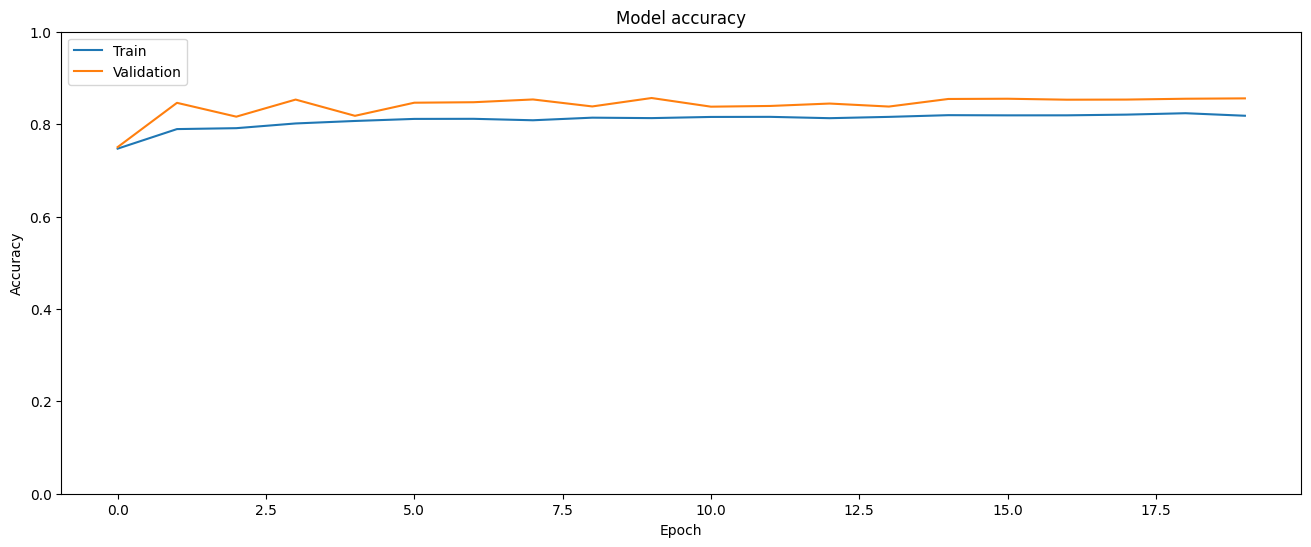

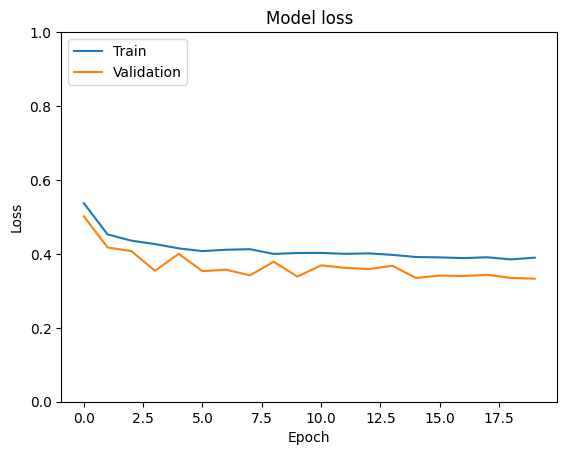

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(advanced_model_history.history['accuracy'])
plt.plot(advanced_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()

plt.plot(advanced_model_history.history['loss'])
plt.plot(advanced_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()



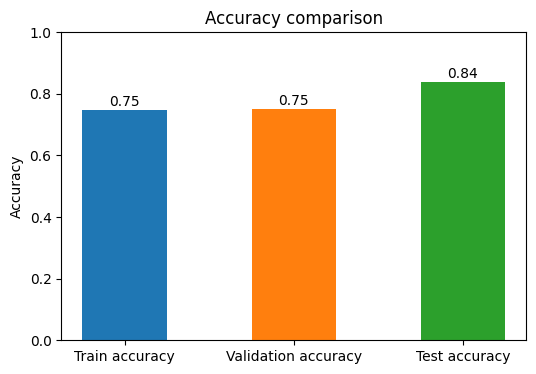

In [ ]:
data = {
    'Train accuracy': advanced_model_history.history['accuracy'][0],
    'Validation accuracy': advanced_model_history.history['val_accuracy'][0],
    'Test accuracy': test_accuracy
}
datasets = list(data.keys())
accuracies = list(data.values())
fig = plt.figure(figsize=(6, 4))
bars = plt.bar(datasets, accuracies, width=0.5, color=['tab:blue', 'tab:orange', 'tab:green'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy comparison")
plt.show()

In [ ]:
test_generator.reset()
test_steps_per_epoch = np.ceil(test_generator.samples / test_generator.batch_size)

predictions = advanced_model.predict(test_generator, steps=test_steps_per_epoch)

predicted_classes = np.round(predictions).astype(int).reshape(-1)
true_classes = test_generator.classes
filenames = test_generator.filenames


4/4 [==============================] - 2s 568ms/step


In [ ]:
correct_indices = np.nonzero(predicted_classes == true_classes)[0]
incorrect_indices = np.nonzero(predicted_classes != true_classes)[0]

correct_samples = np.random.choice(correct_indices, 2, replace=False)
incorrect_samples = np.random.choice(incorrect_indices, 2, replace=False)

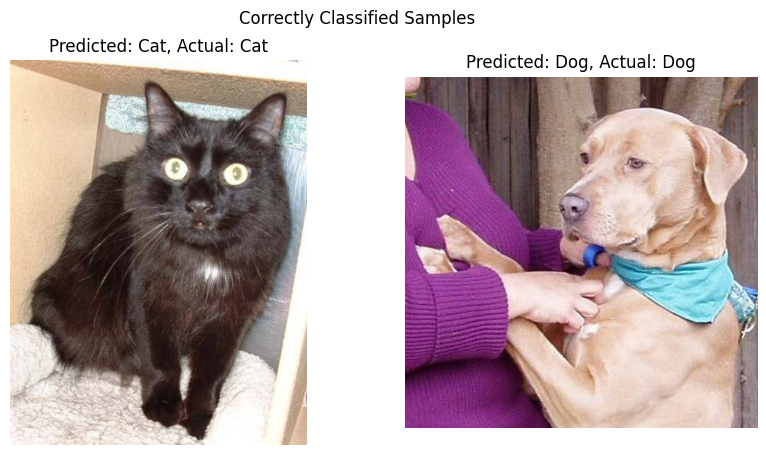

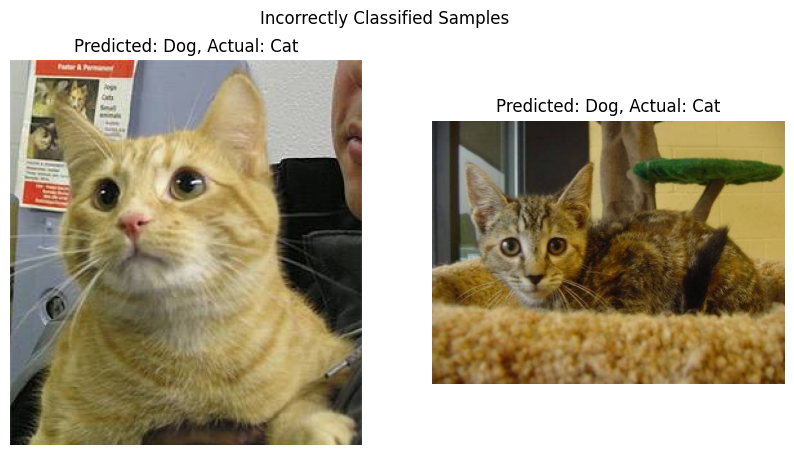

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_images(indices, title, directory, true_classes, predicted_classes, filenames):
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        file_path = os.path.join(directory, filenames[index])
        img = mpimg.imread(file_path)
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(f"Predicted: {'Dog' if predicted_classes[index] else 'Cat'}, "
                  f"Actual: {'Dog' if true_classes[index] else 'Cat'}")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()
plot_images(correct_samples, "Correctly Classified Samples", test_generator.directory, true_classes, predicted_classes, filenames)
plot_images(incorrect_samples, "Incorrectly Classified Samples", test_generator.directory, true_classes, predicted_classes, filenames)


In [ ]:
test_dir = '/content/drive/MyDrive/4483/datasets/test'
test_images = [os.path.join(test_dir, x) for x in os.listdir(test_dir)]
test_df = pd.DataFrame({
    'filename': test_images
})
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col=None,
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 500 validated image filenames.


In [ ]:
predictions = advanced_model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

filenames = [os.path.split(filename)[1].split('.')[0] for filename in test_generator.filenames]
submission_df = pd.DataFrame({
    'id': filenames,
    'label': predicted_classes
})

submission_df['id'] = pd.to_numeric(submission_df['id'])
submission_df.sort_values(by='id', inplace=True)

submission_df.to_csv('/content/drive/MyDrive/4483/datasets/submission.csv', index=False)

500/500 [==============================] - 3s 6ms/step




# CIFAR-10 Dataset



In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.0 MB/s eta 0:00:00


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.maxpool1(self.batch_norm1(self.relu1(self.conv1(x))))
        x = self.maxpool2(self.batch_norm2(self.relu2(self.conv2(x))))
        x = self.maxpool3(self.batch_norm3(self.relu3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout1(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# morre aggressive augumentation and class weight is introduced
num_epochs = 10
batch_size = 4
learning_rate = 0.001

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset.targets), y=train_dataset.targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

accuracy_metric = Accuracy(task='multiclass', num_classes=10).to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)


        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 2000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    running_loss /= len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
    scheduler.step()


model.eval()
#perform testing
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

torch.save(model.state_dict(), 'model.ckpt')


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Step [2000/12500], Loss: 2.1387
Epoch [1/10], Step [4000/12500], Loss: 2.1310
Epoch [1/10], Step [6000/12500], Loss: 1.6800
Epoch [1/10], Step [8000/12500], Loss: 1.0223
Epoch [1/10], Step [10000/12500], Loss: 1.6837
Epoch [1/10], Step [12000/12500], Loss: 1.2065
Epoch [1/10], Loss: 1.6721
Epoch [2/10], Step [2000/12500], Loss: 2.0303
Epoch [2/10], Step [4000/12500], Loss: 1.1885
Epoch [2/10], Step [6000/12500], Loss: 1.5027
Epoch [2/10], Step [8000/12500], Loss: 1.0726
Epoch [2/10], Step [10000/12500], Loss: 0.5761
Epoch [2/10], Step [12000/12500], Loss: 1.1137
Epoch [2/10], Loss: 1.2670
Epoch [3/10], Step [2000/12500], Loss: 0.6701
Epoch [3/10], Step [4000/12500], Loss: 1.4095
Epoch [3/10], Step [6000/12500], Loss: 1.3546
Epoch [3/10], Step [8000/12500], Loss: 0.4231
Epoch [3/10], Step [10000/12500], Loss: 1.7482
Epoch [3/10], Step [12000/12500], Loss: 0.8793
Epoch [3/10], Loss: 1.0885
Epoch [4/